In [12]:
import numpy as np

crop_up = np.load('crop_up.npy')
crop_down = np.load('crop_down.npy')

arr = np.concatenate((crop_up, crop_down), axis=0)


In [13]:
import numpy as np

# Assuming 'data' is your array with the shape (144, 128, 128)

# 1. Normalize the data
data_min = np.min(arr)
data_max = np.max(arr)
normalized_data = (arr - data_min) / (data_max - data_min)

# 2. Reshape the data
data = normalized_data.reshape((144, 128, 128, 1))


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


In [22]:
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

z_mean = Dense(128, name='z_mean')(x)
z_log_var = Dense(128, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(128,))([z_mean, z_log_var])


# ... (the previous code and imports remain unchanged)

# Encoder
input_img = Input(shape=(128, 128, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

z_mean = Dense(256, name='z_mean')(x)
z_log_var = Dense(256, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(256,))([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(256,))
x = Dense(32 * 32 * 128, activation='relu')(decoder_input)
x = Reshape((32, 32, 128))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded, name='decoder')

# VAE construction, loss definition, and training remain largely the same.


In [23]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')


In [24]:
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconstruction_loss *= 128 * 128
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [32]:
vae.fit(data, epochs=50, batch_size=64, shuffle=True)


Epoch 1/50
3/3 [==============================] - 4s 1s/step - loss: 8285.3115
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 8271.2295
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 8198.0957
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 8242.1953
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 8320.5596
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 8277.1826
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 8279.3271
Epoch 8/50
3/3 [==============================] - 4s 1s/step - loss: 8204.7148
Epoch 9/50
3/3 [==============================] - 4s 1s/step - loss: 8285.1553
Epoch 10/50
3/3 [==============================] - 4s 1s/step - loss: 8236.4141
Epoch 11/50
3/3 [==============================] - 4s 1s/step - loss: 8322.7500
Epoch 12/50
3/3 [==============================] - 4s 1s/step - loss: 8058.0742
Epoch 13/50
3/3 [==============================] 

1/1 [==============================] - 0s 33ms/step


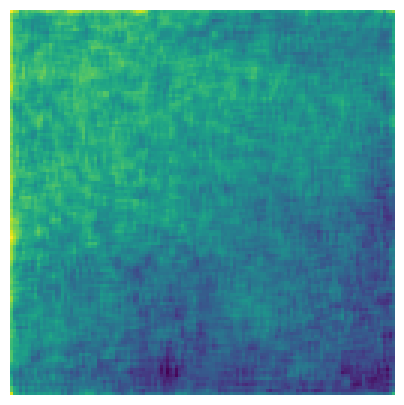

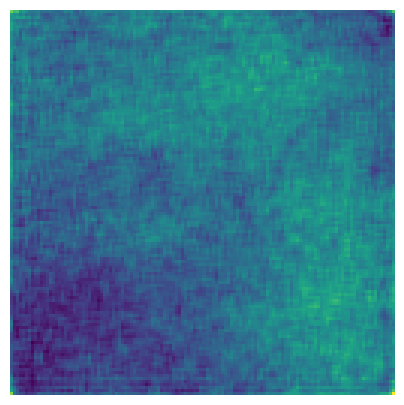

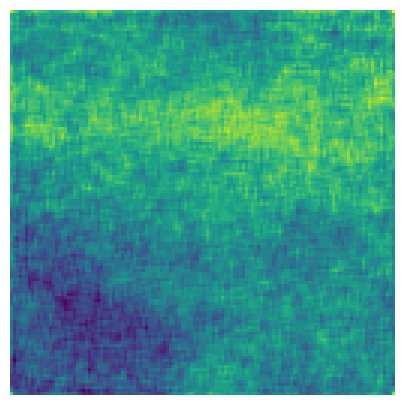

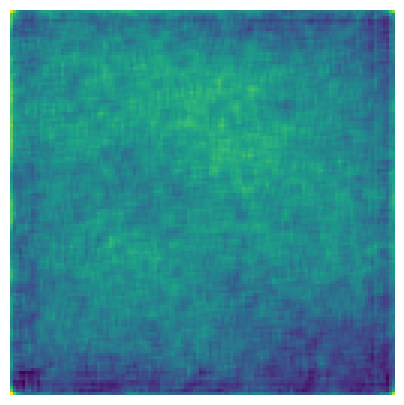

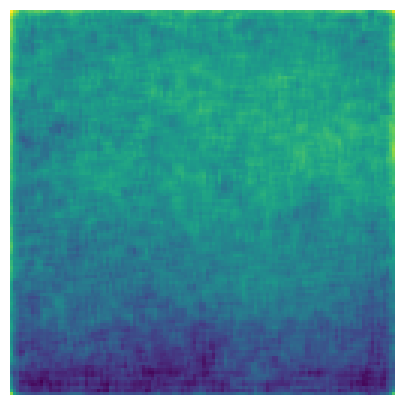

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to generate
num_images = 5

# 1. Sample from the latent space
random_latent_vectors = np.random.normal(size=(num_images, 256))

# 2. Decode them to fake images
generated_images = decoder.predict(random_latent_vectors)

# 3. Plot the generated images
for i in range(num_images):
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_images[i].reshape(128, 128))
    plt.axis('off')
    plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_save_images(decoder, n=5):
    # Sample random points from the latent space
    random_latent_vectors = np.random.normal(size=(n, 256))  # Assuming a 256-dimensional latent space

    # Decode them to images
    generated_images = decoder.predict(random_latent_vectors)

    for i, img in enumerate(generated_images):
        # Reshape the image
        img = img.reshape(128, 128)

        # Save the image
        plt.imsave(f'generated_image_{i}.png', img)

generate_and_save_images(decoder)


1/1 [==============================] - 0s 33ms/step
